In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions
from abtem import Potential, GridScan, PlaneWave, Probe, FrozenPhonons, WavesDetector, CTF, PixelatedDetector, LineScan, AnnularDetector
from abtem import show_atoms
from ase.io import read

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config

config.set({'device': 'cpu'})
config.set({'fft': 'mkl'})
config.set({'progress_bar': 'mkl'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
Z = 8 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional

O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE', epsilon=1)

print('bound electron configuration:', O_transitions.bound_configuration)
print('ionic electron configuration:', O_transitions.excited_configuration)

bound electron configuration: 1s2 2s2 2p4
ionic electron configuration: 1s1 2s2 2p4


In [19]:
transition_potentials = O_transitions.get_transition_potentials(extent=2, gpts=128, energy=300e3)

In [20]:
transition_potentials

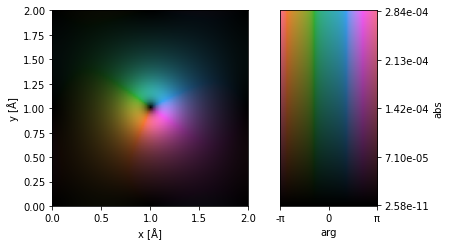

In [21]:
transition_images = transition_potentials.to_images()
transition_images[1].show(cbar=True);

In [22]:
atoms = read('../data/srtio3_100.cif') * (3, 3, 13)

fp = FrozenPhonons(atoms, num_configs=4, sigmas=0.085, ensemble_mean=True)

potential = Potential(fp, gpts=256, slice_thickness=2, parametrization='lobato', projection='infinite', exit_planes=1)

waves = PlaneWave(energy=300e3)

waves.grid.match(potential)

detectors = [PixelatedDetector(fourier_space=False)] # detect real space image

ctf = CTF(semiangle_cutoff=25) # 25 mrad objective aperture

images = waves.multislice(potential, 
                          detectors=detectors, 
                          ctf=ctf,
                          transition_potentials=transition_potentials,
                         )

images.compute()

In [7]:
from dask.distributed import Client, Pub
import time

c = Client()


/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56265 instead
  warnings.warn(


In [16]:
import dask
class A:
    
    def __init__(self):
        self.a = 0
        
        

def slow_func(a):
    q = Pub('progress')
    
    for i in range(10):
        
        #d = np.zeros((1,1)) + i
        a.a = i
        q.put(i)
        time.sleep(1)

a = A()
   
    
v = dask.delayed(slow_func)(a)


#c.submit(slow_func, a=a)


In [17]:
v.compute()

In [18]:
a.a

0

In [5]:
from dask.distributed import Client, Sub
q = Sub('progress')
while True:
    print(q.get())

4
5
6
7
8
9


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

distributed.nanny - WARNING - Restarting worker


Traceback (most recent call last):
  File "/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-e072697c770b>", line 4, in <module>
    print(q.get())
  File "/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/distributed/pubsub.py", line 441, in get
    return self.client.sync(self._get, timeout=timeout)
  File "/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/distributed/client.py", line 853, in sync
    return sync(
  File "/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/distributed/utils.py", line 351, in sync
    e.wait(10)
  File "/opt/anaconda3/envs/abtem-dask/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/opt/anaconda3/envs/abtem-dask/lib/python3.8/threading.py", line 306, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt

During handling of t

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


TypeError: object of type 'NoneType' has no len()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [41]:
from tqdm.dask import TqdmCallback
import dask.array as da

arr = da.ones((10,) + (1000,) * 2, chunks=(1,-1,-1))

arr = da.fft.fft2(arr)

with TqdmCallback(desc="compute"):
    
    arr.compute()

# or use callback globally
#cb = TqdmCallback(desc="global")
#cb.register()
#arr.compute()

compute:   0%|          | 0/10 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fea1c32b850>)

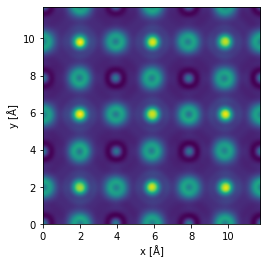

In [15]:
images[-1].show()